In [81]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score,precision_score,recall_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost
from imblearn.over_sampling import SMOTE

import tensorflow as tf
import keras 
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense,Dropout
from imblearn.over_sampling import SMOTE
from keras.regularizers import l1_l2

import warnings
warnings.filterwarnings('ignore')

In [51]:
feature_data = pd.read_csv('https://raw.githubusercontent.com/rsdevanathan/Customer_Subscription/main/feature_data.csv')

In [52]:
feature_data.head()

,age,duration,campaign,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,...,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y
0,0.889105,-0.115910,0.655440,-0.361371,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,-0.289767,-0.222792,-0.215515,1.744512,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,3.049388,3.821615,-0.650993,-0.361371,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,-0.388006,-0.573364,-0.215515,-0.361371,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.871499,0.486903,-0.215515,-0.361371,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


## Train Test Split - 80:20

In [53]:
X = feature_data.drop(columns = 'y')
y = feature_data[['y']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 14)
cw = {0:1,1:np.count_nonzero(y_train==0)/np.count_nonzero(y_train==1)}

### Metric Utility

In [54]:
def metric_utility(model,X_train, y_train,X_test,y_test):
  y_pred = model.predict(X_test)
  kfold = StratifiedKFold(n_splits=3, shuffle=True)
  cv_auc = cross_val_score(model, X_train, y_train, scoring='roc_auc',cv=kfold)
  metric_df =  pd.DataFrame({
                             'Train_AUC' :np.mean(cv_auc),
                             'Test_AUC' :[roc_auc_score(y_test,y_pred)],
                             'Test_Accuracy' :[accuracy_score(y_test,y_pred)],
                             'Test_F1_score' :[f1_score(y_test,y_pred)],
                             'Test_Precision' :[precision_score(y_test,y_pred)],
                             'Test_Recall' :[recall_score(y_test,y_pred)]})
  #print(metric_df)
  cm = confusion_matrix(y_test, y_pred, labels=[0., 1.])
  disp = ConfusionMatrixDisplay(cm)
  disp.plot();
  return metric_df

## Logistic regression - Base Model

,Train_AUC,Test_AUC,Test_Accuracy,Test_F1_score,Test_Precision,Test_Recall
0,0.913407,0.664138,0.907005,0.452594,0.627792,0.353846


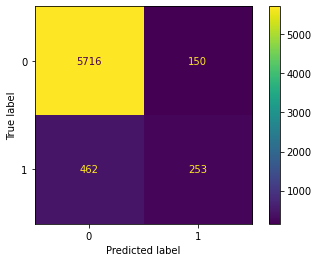

In [55]:
ml_lr_base = LogisticRegression(max_iter=1000)
ml_lr_base.fit(X_train,y_train)
y_pred = ml_lr_base.predict(X_test)
metric_utility(ml_lr_base,X_train, y_train,X_test,y_test)

The base model of Linear Regression has high Accuracy but all other metrics are poor. Also the train AUC is much higher than the Test AUC. It is due to the imbalance in the target variable as visible in the confusion matrix. The model is performing poor in identifying subscriptions. The false negative is too high causing poor recall score.

Below, I have tried oversampling the data using SMOTE package to handle the imbalanced target variable. The Logistic Regression is performing much better after the resampling.

In [56]:
smote_sampler = SMOTE(random_state=14)
columns = X_train.columns
arr_X, arr_y = smote_sampler.fit_resample(X_train, y_train)
sampled_X = pd.DataFrame(data=arr_X,columns=X_train.columns )
sampled_y = pd.DataFrame(data=arr_y,columns=['y'])

,Train_AUC,Test_AUC,Test_Accuracy,Test_F1_score,Test_Precision,Test_Recall
0,0.913613,0.830584,0.851238,0.54016,0.406648,0.804196


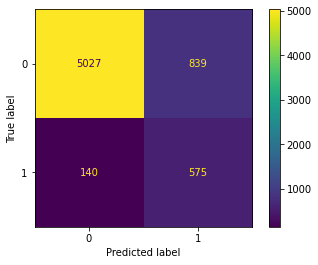

In [57]:
ml_lr = LogisticRegression(max_iter=1000)
ml_lr.fit(sampled_X,sampled_y)
metric_utility(ml_lr,X_train, y_train,X_test,y_test)

## Linear Regression Feature Importance

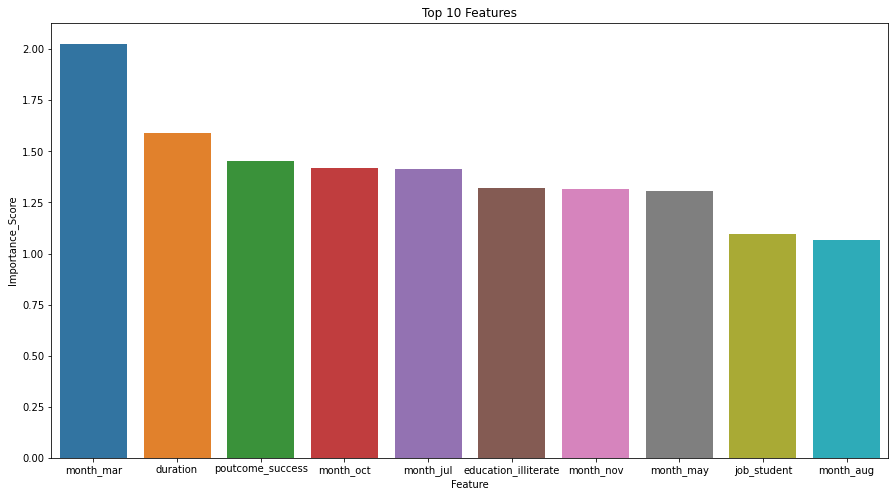

In [86]:
importance_df = pd.DataFrame({'Feature':X_train.columns,'Importance_Score':np.abs(ml_lr.coef_[0])})
plot_df = importance_df.nlargest(10, ['Importance_Score'])
plt.figure(figsize=(15,8))
ax = sns.barplot(x="Feature", y="Importance_Score", data=plot_df).set(title='Top 10 Features')
plt.show()

## KNN Classifier - with Hyper Parameter Tuning

In [58]:
%%time
ml_knn_hp=KNeighborsClassifier()
param_grid = { 
    'leaf_size': list(range(5,20)),
    'n_neighbors': list(range(5,20)),
    'p' : [1,2],
}
CV_knn = RandomizedSearchCV(estimator=ml_knn_hp, param_distributions=param_grid,scoring='roc_auc', n_iter = 20, cv = 3,n_jobs = -1,verbose=10)
CV_knn.fit(sampled_X, sampled_y)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
CPU times: user 4.4 s, sys: 679 ms, total: 5.07 s
Wall time: 11min 41s


In [59]:
CV_knn.best_params_

{'leaf_size': 7, 'n_neighbors': 7, 'p': 1}

,Train_AUC,Test_AUC,Test_Accuracy,Test_F1_score,Test_Precision,Test_Recall
0,0.830518,0.729244,0.857772,0.463303,0.392614,0.565035


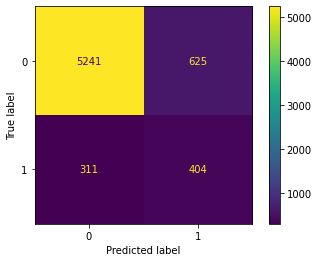

In [60]:
ml_knn=KNeighborsClassifier(leaf_size=7,n_neighbors=7,p=1)
ml_knn.fit(sampled_X, sampled_y)
metric_utility(ml_knn,X_train, y_train,X_test,y_test)

## SVC - with Hyperparameter tuning

In [64]:
%%time
ml_svc_hp=SVC(gamma='auto')
param_grid = {'C': [1, 10, 100]}
CV_svc = RandomizedSearchCV(estimator=ml_svc_hp, param_distributions=param_grid,scoring='roc_auc', n_iter = 20, cv = 3,n_jobs = -1,verbose=10)
CV_svc.fit(sampled_X, sampled_y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
CPU times: user 3min 8s, sys: 1.66 s, total: 3min 10s
Wall time: 27min 20s


In [65]:
CV_svc.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

,Train_AUC,Test_AUC,Test_Accuracy,Test_F1_score,Test_Precision,Test_Recall
0,0.892375,0.724203,0.887099,0.498312,0.481723,0.516084


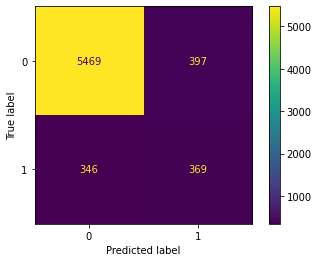

In [66]:
ml_svc=SVC(gamma=0.1,C=10,kernel='rbf')
ml_svc.fit(sampled_X, sampled_y)
metric_utility(ml_svc,X_train, y_train,X_test,y_test)

## Random Forest Classifier - with Hyperparameter Tuning

In [ ]:
%%time

ml_rf_hp=RandomForestClassifier(class_weight = cw,random_state=14)
param_grid = { 
    'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)],
    'max_features': ['auto', 'sqrt','log2'],
    'max_depth' : [10,20,50,100],
    'min_samples_leaf': [2,5,10],
}
CV_rf = RandomizedSearchCV(estimator=ml_rf_hp, param_distributions=param_grid,scoring='roc_auc', n_iter = 20, cv = 3,n_jobs = -1,verbose=10)
CV_rf.fit(X_train, y_train)

In [ ]:
CV_rf.best_params_

,Train_AUC,Test_AUC,Test_Accuracy,Test_F1_score,Test_Precision,Test_Recall
0,0.926395,0.842996,0.870081,0.574838,0.445988,0.808392


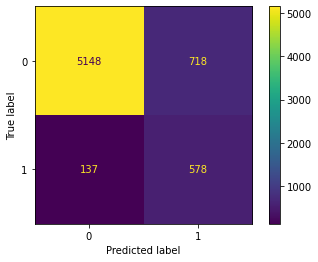

In [67]:
ml_rf=RandomForestClassifier(random_state=14,class_weight = cw,max_depth=100,max_features='sqrt',min_samples_leaf=5,n_estimators=500)
ml_rf.fit(X_train, y_train)
metric_utility(ml_rf,X_train, y_train,X_test,y_test)

# Random Forest Feautre Importance

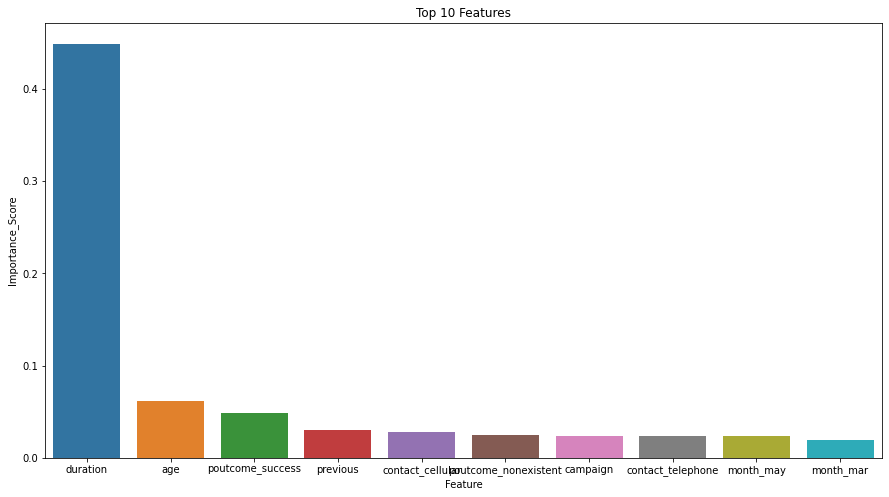

In [87]:
importance_df = pd.DataFrame({'Feature':X_train.columns,'Importance_Score':np.abs(ml_rf.feature_importances_)})
plot_df = importance_df.nlargest(10, ['Importance_Score'])
plt.figure(figsize=(15,8))
ax = sns.barplot(x="Feature", y="Importance_Score", data=plot_df).set(title='Top 10 Features')
plt.show()

## XGBoost - with Hyper Parameter Tuning

In [ ]:
%%time
ml_xgb_hp = xgboost.XGBClassifier(objective='binary:logistic')

param_grid = [
  {
    'clf__n_estimators': [50, 100, 150, 200],
    'clf__learning_rate': [0.01, 0.1, 0.001],
    'clf__max_depth': range(50,200),
    'clf__colsample_bytree': [0.1,0.2,0.5],
    'clf__gamma': [0.1,0.2],
  }
]

CV_xgb = RandomizedSearchCV(estimator=ml_xgb_hp,param_distributions=param_grid,scoring='roc_auc', n_iter = 20, cv = 3,n_jobs = -1,verbose=10)
CV_xgb.fit(sampled_X, sampled_y)

In [ ]:
CV_xgb.best_params_

In [ ]:
ml_xgb=xgboost.XGBClassifier(objective='binary:logistic',random_state=14,max_depth=30,colsample_bytree=0.5,gamma=0.1,learning_rate= 0.001,n_estimators=200)
ml_xgb.fit(sampled_X, sampled_y)
metric_utility(ml_xgb,X_train, y_train,X_test,y_test)

## XGBoost Feature importance

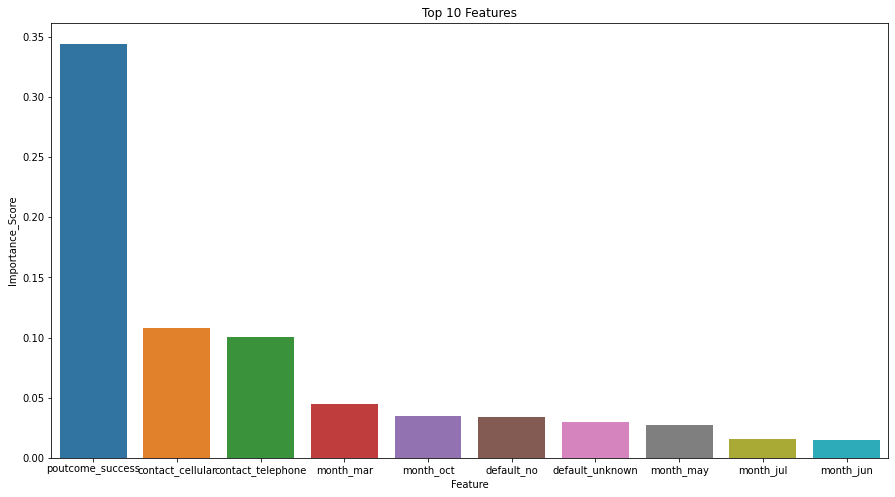

In [88]:
importance_df = pd.DataFrame({'Feature':X_train.columns,'Importance_Score':np.abs(ml_xgb.feature_importances_)})
plot_df = importance_df.nlargest(10, ['Importance_Score'])
plt.figure(figsize=(15,8))
ax = sns.barplot(x="Feature", y="Importance_Score", data=plot_df).set(title='Top 10 Features')
plt.show()

## NN - Base

,Train_AUC,Test_AUC,Test_Accuracy,Test_F1_score,Test_Precision,Test_Recall
0,0.912691,0.77528,0.864306,0.51441,0.420819,0.661538


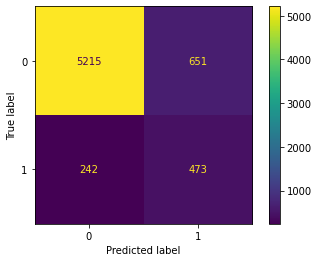

In [89]:
def create_nn():
  model = Sequential()
  model.add(Dense(32, input_dim=57, activation='relu'))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
  return model
dl_cfr = KerasClassifier(build_fn=create_nn, epochs=100, batch_size=256, verbose=0)
dl_cfr.fit(sampled_X, sampled_y)
metric_utility(dl_cfr,X_train, y_train,X_test,y_test)

## NN - Class Weights

,Train_AUC,Test_AUC,Test_Accuracy,Test_F1_score,Test_Precision,Test_Recall
0,0.922327,0.844756,0.858988,0.56019,0.423656,0.826573


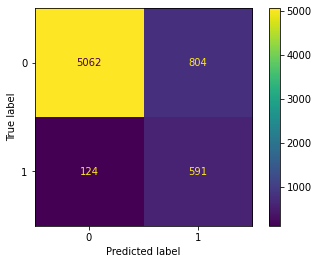

In [90]:
def create_nn():
  model = Sequential()
  model.add(Dense(32, input_dim=57, activation='relu'))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
  return model
dl_cfr_cw = KerasClassifier(build_fn=create_nn, epochs=100, batch_size=1028, verbose=0)
dl_cfr_cw.fit(X_train, y_train,class_weight = cw)
metric_utility(dl_cfr_cw,X_train, y_train,X_test,y_test)

## NN - Dropout and Regularization

,Train_AUC,Test_AUC,Test_Accuracy,Test_F1_score,Test_Precision,Test_Recall
0,0.880053,0.83815,0.823127,0.512971,0.36597,0.857343


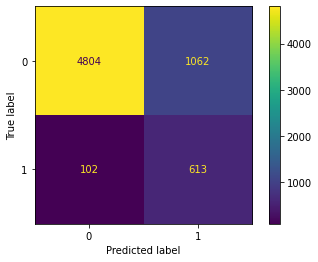

In [91]:
def create_nn():
  model = Sequential()
  model.add(Dense(32, input_dim=57,kernel_regularizer=l1_l2(l1=0.01, l2=0.01), bias_regularizer=l1_l2(l1=0.01, l2=0.01), activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(16,kernel_regularizer=l1_l2(l1=0.01, l2=0.01), bias_regularizer=l1_l2(l1=0.01, l2=0.01), activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
  return model
dl_cfr_reg = KerasClassifier(build_fn=create_nn, epochs=100, batch_size=1028, verbose=0)
dl_cfr_reg.fit(X_train, y_train,class_weight = cw)
metric_utility(dl_cfr_reg,X_train, y_train,X_test,y_test)

## ML Experiments Code - Excluding Hyperparameter tuning and Plots

In [97]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score,precision_score,recall_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

def metric_utility(model,X_train, y_train,X_test,y_test):
  y_pred = model.predict(X_test)
  kfold = StratifiedKFold(n_splits=3, shuffle=True)
  cv_auc = cross_val_score(ml_lr_base, X_train, y_train, scoring='roc_auc',cv=kfold)
  metric_df =  pd.DataFrame({
                             'Train_AUC' :np.mean(cv_auc),
                             'Test_AUC' :[roc_auc_score(y_test,y_pred)],
                             'Test_Accuracy' :[accuracy_score(y_test,y_pred)],
                             'Test_F1_score' :[f1_score(y_test,y_pred)],
                             'Test_Precision' :[precision_score(y_test,y_pred)],
                             'Test_Recall' :[recall_score(y_test,y_pred)]})
  return metric_df

feature_data = pd.read_csv('https://raw.githubusercontent.com/rsdevanathan/Customer_Subscription/main/feature_data.csv')
X = feature_data.drop(columns = 'y')
y = feature_data[['y']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 14)


## Model 1 - Logistic Regression - Base

ml_lr_base = LogisticRegression(max_iter=1000)
ml_lr_base.fit(X_train,y_train)
ml_lr_base_metrics = metric_utility(ml_lr_base,X_train, y_train,X_test,y_test)
ml_lr_base_metrics.insert(loc=0, column='Model Name', value='LR-BASE')

## Model 2 - Logistic Regression - Oversampled

ml_lr = LogisticRegression(max_iter=1000)
ml_lr.fit(sampled_X,sampled_y)
ml_lr_metrics = metric_utility(ml_lr,X_train, y_train,X_test,y_test)
ml_lr_metrics.insert(loc=0, column='Model Name', value='LR-OS')

## Model 3 - KNN

ml_knn=KNeighborsClassifier(leaf_size=14,n_neighbors=7,p=1)
ml_knn.fit(sampled_X, sampled_y)
ml_knn_metrics = metric_utility(ml_knn,X_train, y_train,X_test,y_test)
ml_knn_metrics.insert(loc=0, column='Model Name', value='KNN')

## Model 4 - SVC

ml_svc=SVC(gamma=0.1,C=10,kernel='rbf')
ml_svc.fit(sampled_X, sampled_y)
ml_svc_metrics = metric_utility(ml_svc,X_train, y_train,X_test,y_test)
ml_svc_metrics.insert(loc=0, column='Model Name', value='SVC')

## Model 5 - Random Forest

ml_rf=RandomForestClassifier(random_state=14,class_weight = cw,max_depth=100,max_features='sqrt',min_samples_leaf=5,n_estimators=500)
ml_rf.fit(X_train, y_train)
ml_rf_metrics = metric_utility(ml_rf,X_train, y_train,X_test,y_test)
ml_rf_metrics.insert(loc=0, column='Model Name', value='RF')


## Model 6 - Xgboost

ml_xgb=xgboost.XGBClassifier(objective='binary:logistic',random_state=14,max_depth=30,colsample_bytree=0.5,gamma=0.1,learning_rate= 0.001,n_estimators=200)
ml_xgb.fit(sampled_X, sampled_y)
ml_xgb_metrics = metric_utility(ml_xgb,X_train, y_train,X_test,y_test)
ml_xgb_metrics.insert(loc=0, column='Model Name', value='XGB')

## Model 7 - NN Base

def create_nn():
  model = Sequential()
  model.add(Dense(32, input_dim=57, activation='relu'))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
  return model
dl_cfr = KerasClassifier(build_fn=create_nn, epochs=100, batch_size=256, verbose=0)
dl_cfr.fit(sampled_X, sampled_y)
dl_cfr_metrics = metric_utility(dl_cfr,X_train, y_train,X_test,y_test)
dl_cfr_metrics.insert(loc=0, column='Model Name', value='NN - Base')

## Model 8 - NN CW

def create_nn():
  model = Sequential()
  model.add(Dense(32, input_dim=57, activation='relu'))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
  return model
dl_cfr_cw = KerasClassifier(build_fn=create_nn, epochs=100, batch_size=1028, verbose=0)
dl_cfr_cw.fit(X_train, y_train,class_weight = cw)
dl_cfr_cw_metrics = metric_utility(dl_cfr_cw,X_train, y_train,X_test,y_test)
dl_cfr_cw_metrics.insert(loc=0, column='Model Name', value='NN - CW')

## Model 9 - NN Regularization

def create_nn():
  model = Sequential()
  model.add(Dense(32, input_dim=57,kernel_regularizer=l1_l2(l1=0.01, l2=0.01), bias_regularizer=l1_l2(l1=0.01, l2=0.01), activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(16,kernel_regularizer=l1_l2(l1=0.01, l2=0.01), bias_regularizer=l1_l2(l1=0.01, l2=0.01), activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
  return model
dl_cfr_reg = KerasClassifier(build_fn=create_nn, epochs=100, batch_size=1028, verbose=0)
dl_cfr_reg.fit(X_train, y_train,class_weight = cw)
dl_cfr_reg_metrics = metric_utility(dl_cfr_reg,X_train, y_train,X_test,y_test)
dl_cfr_reg_metrics.insert(loc=0, column='Model Name', value='NN - Reg')

Final_Metrics = pd.concat([ml_lr_base_metrics,ml_lr_metrics,ml_knn_metrics,ml_svc_metrics,ml_rf_metrics,ml_xgb_metrics,dl_cfr_metrics,dl_cfr_cw_metrics,dl_cfr_reg_metrics],axis=0)


In [98]:
Final_Metrics.head(10)

,Model Name,Train_AUC,Test_AUC,Test_Accuracy,Test_F1_score,Test_Precision,Test_Recall
0,LR-BASE,0.913622,0.664138,0.907005,0.452594,0.627792,0.353846
0,LR-OS,0.913848,0.830584,0.851238,0.540160,0.406648,0.804196
0,KNN,0.914532,0.729244,0.857772,0.463303,0.392614,0.565035
0,SVC,0.914074,0.724203,0.887099,0.498312,0.481723,0.516084
0,RF,0.913645,0.842996,0.870081,0.574838,0.445988,0.808392
0,XGB,0.913960,0.688495,0.908828,0.492386,0.623126,0.406993
0,NN - Base,0.914307,0.763936,0.865978,0.506711,0.422181,0.633566
0,NN - CW,0.914116,0.843915,0.824647,0.518364,0.369423,0.868531
0,NN - Reg,0.913042,0.834893,0.818417,0.505994,0.359155,0.855944


## Experimentation Summary

Given the problem statement of subscription campaign, Type I Error(False Positives) might be more acceptable than Type II error, since the campaign might benifit from wider net(assuming the reasonable campaign cost). Hence I would prioritize the models having high recall with a acceptible trade-off on precision.

From the above data, Logistic Regression(oversampled), Random Forest(HP Tuned) and NN(with Classweight) are suitable for the given problem statement and are used for Final prediction of this exercise.

End